# Sentiment Analysis

## Build Model

In [3]:
import pandas as pd

df = pd.read_csv("Data\Genshin_Impact.csv",encoding='utf-8')
df.dropna(subset = ["content"], inplace = True)
df.drop_duplicates(keep = "first", inplace = True)
print(str(df.shape[0]) + " comments and their related information are scrapped from Bilibili Game Center.")
df.head()

256732 comments and their related information are scrapped from Bilibili Game Center.


Unnamed: 0             name  level             datetime       content  \
0           0   bili_235060966      5  2019-06-07 17:31:06  Âú®ÔºüÊàëÊòØÁ¨¨‰∏Ä‰∏™È¢ÑÁ∫¶ÁöÑÂêóÔºü   
1           1      KAMISAMAÊòØÈòøÁ¨ë      5  2019-06-07 17:35:17          ÊúüÂæÖÊúüÂæÖ   
2           2            ÈÅô„Åã„Å™„ÇãÂ§¢      5  2019-06-07 17:38:56          Êù•‰∫ÜÊù•‰∫Ü   
3           3             ÊâìÂÄíË±ÜË±Ü      6  2019-06-07 17:46:44         ÈùûÂ∏∏ÁöÑÊúüÂæÖ   
4           4  MitsuharuYosaka      5  2019-06-07 17:47:23          Â•ΩÊúüÂæÖÂïä   

   grade  up  down  rcount  
0      8  21    11       3  
1     10   6    12       0  
2      8   5    10       0  
3     10   5    11       0  
4     10   5     8       0

In [4]:
import jieba

extra_words = ["Ê∞™Èáë", "È™óÊ∞™", "ÁôΩÂ´ñ", "Èõ∂Ê∞™", "ÂæÆÊ∞™", "ÂèàËÇù", 
               "Á±≥ÂìàÊ∏∏", "Á±≥Âç´ÂÖµ", "‰∫ëÁé©ÂÆ∂", "Âá∫Ë¥ßÁéá", "Âú£ÈÅóÁâ©", "Êµ∑ÁÅØËäÇ", 
               "ÂºÄÊîæ‰∏ñÁïå", "Êú™Êù•ÂèØÊúü", "ÊñáÂåñËæìÂá∫", "3AÂ§ß‰Ωú", "Êï∞ÂÄºËÜ®ËÉÄ", "ÂñÇ‰∏çÈ•±ÁöÑÁãº"]

for word in extra_words:
    jieba.add_word(word, freq = df[df["content"].str.contains(word)].shape[0])
    
df.drop(df[df["content"].str.contains("|".join(["---", "‚Äî‚Äî‚Äî", "2019", "2020", "2021"]))].index, inplace = True)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\rgdfy\AppData\Local\Temp\jieba.cache
Loading model cost 0.755 seconds.
Prefix dict has been built successfully.


In [5]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
seed = 123

pos = df[df["grade"] > 6]["content"]
pos_train, pos_test = train_test_split(pos, test_size = test_ratio, random_state = seed, shuffle = True)
textfile = open("Data/pos.txt", "w",encoding='utf-8')
for comment in pos_train:
    textfile.write(comment + "\n")
textfile.close()

neg = df[df["grade"] <= 6]["content"]
neg_train, neg_test = train_test_split(neg, test_size = test_ratio, random_state = seed, shuffle = True)
textfile = open("Data/neg.txt", "w",encoding='utf-8')
for comment in neg_train:
    textfile.write(comment + "\n")
textfile.close()

In [11]:
from snownlp import sentiment
from snownlp import SnowNLP
from tqdm import tqdm
sentiment.train("Data/neg.txt", "Data/pos.txt")
sentiment.save(r"C:\Users\rgdfy\AppData\Local\Programs\Python\Python38\Lib\site-packages\snownlp\sentiment\sentiment.marshal")
pos_results = [SnowNLP(comment).sentiments for comment in tqdm(pos_test)]
neg_results = [SnowNLP(comment).sentiments for comment in tqdm(neg_test)]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 26831/26831 [06:30<00:00, 68.63it/s]


In [12]:
accuracy = []
thresholds = [i / 1000 for i in range(1001)]
for x in thresholds:
    correct = 0
    for result in pos_results:
        if (result >= x):
            correct += 1
    for result in neg_results:
        if (result < x):
            correct += 1
    accuracy.append(correct / (len(pos_test) + len(neg_test)) * 100)
threhold = accuracy.index(max(accuracy)) / 1000
print("Accuracy: " + str(round(max(accuracy), 2)) + "%")

Accuracy: 79.22%


## Apply Model to Video Comments

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from snownlp import sentiment
from snownlp import SnowNLP
from tqdm import tqdm

In [14]:
df = pd.read_csv("43.csv")
#df.drop("Unnamed: 0", axis = 1, inplace = True)
df.dropna(subset = ["content"], inplace = True)
df.drop_duplicates(keep = "first", inplace = True)
print(str(df.shape[0]) + " comments and their related information are scrapped from Target Video.")
df.head()

63939 comments and their related information are scrapped from Target Video.


mid        name         datetime  type           content
0   702014461         ÈüµË±êÊÅµ  2023/12/8 19:46     0            ÂéüÊù•ÊòØ‰ªäÂ§©Âêó
1   405233012        ‰πêÁöÑÊ¢¶Âπª  2023/12/8 19:46     0                ÂºÄ‰∫Ü
2  1925658916     ËìùÊòü‰∏äÁöÑÂàÜÂéüÂ≠ê  2023/12/8 19:46     0  ÊàëÁöÑÊµÅÈáè[ÊíáÂò¥][ÊíáÂò¥][ÊíáÂò¥]
3  1655969602  Êùé‰ø°yydsÊàëÁà±Êùé‰ø°  2023/12/8 19:46     0            Â∑ÆÁÇπÂ∞±ÁªôÂøò‰∫Ü
4   299613087        È™öÁéñ‰∏çÈ™ö  2023/12/8 19:46     0             ÂêéÈù¢ÁöÑÊòØ.

In [15]:
df["date"] = [t.split(" ")[0] for t in list(df["datetime"])]
df["sentiment"] = [1 if SnowNLP(comment).sentiments >= threhold else -1 for comment in list(df["content"])]

### Simple Polarity Analysis

In [23]:
df

mid        name         datetime  type           content  \
0             702014461         ÈüµË±êÊÅµ  2023/12/8 19:46     0            ÂéüÊù•ÊòØ‰ªäÂ§©Âêó   
1             405233012        ‰πêÁöÑÊ¢¶Âπª  2023/12/8 19:46     0                ÂºÄ‰∫Ü   
2            1925658916     ËìùÊòü‰∏äÁöÑÂàÜÂéüÂ≠ê  2023/12/8 19:46     0  ÊàëÁöÑÊµÅÈáè[ÊíáÂò¥][ÊíáÂò¥][ÊíáÂò¥]   
3            1655969602  Êùé‰ø°yydsÊàëÁà±Êùé‰ø°  2023/12/8 19:46     0            Â∑ÆÁÇπÂ∞±ÁªôÂøò‰∫Ü   
4             299613087        È™öÁéñ‰∏çÈ™ö  2023/12/8 19:46     0             ÂêéÈù¢ÁöÑÊòØ.   
...                 ...         ...              ...   ...               ...   
68549         173279517        Ê∞¥ÊµÅ‰∏âÁîü  2023/12/8 21:35     0       ‰ªÄ‰πàÊÅ∂È≠îÁî≤Êñπ[dog]   
68550        2011427523     ÂñúÊ¨¢ÂêÉ‰ªôË¥ùÈõ™È•º  2023/12/8 21:35     0               Â∞±Ê≤°‰∫Ü   
68551         435411123        ‰∏îÊï£ÊÑÅÂøÉ  2023/12/8 21:35     0            ÂÆ∂‰∫∫‰ª¨ÔºåÊãúÊãú   
68552        1895515151       ÂøÉÁÉ¶ÁöÑËÆ∏È£û  2023/12/8 21:35     0                ÁâõÈÄº   
68553  3546380000000000        ËÉ°ËêùË¥ùÂêâ  2023/12/8 21:35     0                 6   

            date  sentiment  
0      2023/12/8         -1  
1      2023/12/8         -1  
2      2023/12/8          1  
3      2023/12/8          1  
4      2023/12/8         -1  
...          ...        ...  
68549  2023/12/8         -1  
68550  2023/12/8         -1  
68551  2023/12/8         -1  
68552  2023/12/8         -1  
68553  2023/12/8          1  

[63939 rows x 7 columns]

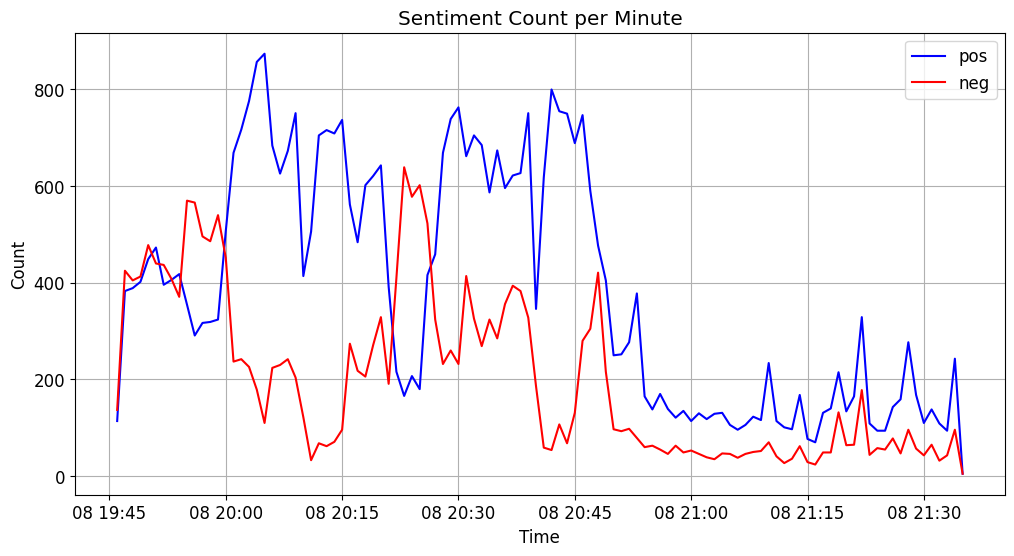

In [24]:
df['datetime'] = pd.to_datetime(df['datetime'])

# ÊåâÂàÜÈíüÂàÜÁªÑÂπ∂ÁªüËÆ°ÊØèÂàÜÈíü sentiment ÂÄº‰∏∫1Âíå-1ÁöÑÊï∞Èáè
positive_sentiments = df[df['sentiment'] == 1].groupby(pd.Grouper(key='datetime', freq='T')).size()
negative_sentiments = df[df['sentiment'] == -1].groupby(pd.Grouper(key='datetime', freq='T')).size()

# ÂêàÂπ∂‰∏§‰∏™SeriesÔºåÂπ∂Â°´ÂÖÖNaN‰∏∫0
summary = pd.concat([positive_sentiments.rename('pos'), negative_sentiments.rename('neg')], axis=1).fillna(0)

# ÁîªÂõæ
plt.figure(figsize=(12, 6))

plt.plot(summary.index, summary['pos'], label='pos', color='blue')
plt.plot(summary.index, summary['neg'], label='neg', color='red')

plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Sentiment Count per Minute')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
df1

rpid        oid        mid        name  level  \
0      5479781237  720739815   24839224    IKEHOSHI      5   
1      5479773459  720739815  152431077        ÊôöÁù°‰ºöÈ£ò      5   
2      5479773554  720739815   37922740   PalpitaZz      5   
3      5479781553  720739815  124668951        Êà∞‰∏®ÊòüÁ•û      5   
4      5479777337  720739815  122549284         ÂëÜÂ∞èÈ∫ª      5   
...           ...        ...        ...         ...    ...   
73483  5550835976  720739815   22738659          Ê≤âÁ≤ï      6   
73484  5552223716  720739815   11204302       Faiz„Çû      5   
73485  5553389126  720739815      87644  bili_87644      5   
73486  5555829297  720739815  639706141     Ê≤≥ÂçóËêΩÊ¶úÁæéÊúØÁîü      4   
73487  5556073569  720739815  517182589      mdawsl      3   

                  datetime                                            content  \
0      2021-09-28 12:00:44                                               ÔºüÔºÅÂàöÂàö   
1      2021-09-28 12:00:46                                              ÁîüÊó•Âø´‰πêÂëÄ   
2      2021-09-28 12:00:49                                                 Êù•‰∫Ü   
3      2021-09-28 12:00:52                                          [ÁÉ≠ËØçÁ≥ªÂàó_Â•ΩËÄ∂]   
4      2021-09-28 12:00:52                                                 Êù•ÂíØ   
...                    ...                                                ...   
73483  2021-10-08 22:20:46                                    ÊàëÊù•ÁªôÁàπÊÑüÊÅ©Êà¥Âæ∑‰∫Ü[doge]   
73484  2021-10-09 07:12:36                                       BV1Jf4y1c7ri   
73485  2021-10-09 12:41:55  Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫ÂøÉÊµ∑Âä†Âº∫...   
73486  2021-10-09 20:18:34                                          [ÁÉ≠ËØçÁ≥ªÂàó_ÊâìÂç°]   
73487  2021-10-09 20:54:26                 Ë∞ÅËøòËÆ∞ÂæóÊ¥æËíôÊòØ‰∏™ÂêëÂØº[ËÑ±Âçïdoge][ËÑ±Âçïdoge][ËÑ±Âçïdoge]   

       like  rcount        date  sentiment  
0         6       0  2021-09-28          1  
1         2       0  2021-09-28          1  
2         2       0  2021-09-28         -1  
3        15       0  2021-09-28          1  
4         4       0  2021-09-28         -1  
...     ...     ...         ...        ...  
73483     3       0  2021-10-08          1  
73484     2       1  2021-10-09          1  
73485     2       0  2021-10-09          1  
73486     0       0  2021-10-09          1  
73487     2       0  2021-10-09          1  

[73488 rows x 11 columns]

In [25]:
sentiment_df = df[df['sentiment'] == -1]

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
top_15_mids = sentiment_df['mid'].value_counts().head(15)

# ÊâìÂç∞ mid ÂíåÂá∫Áé∞Ê¨°Êï∞ÂèäÂÖ∂ÂØπÂ∫îÁöÑ content Âíå level ÂÄº
for mid, count in top_15_mids.items():
    subset = sentiment_df[sentiment_df['mid'] == mid]
    content_values = subset['content'].tolist()
    x=len(''.join(content_values))
    print(f'mid: {mid}, count: {count},len:{x}')
    print(f'content: {content_values}')
    print('-------------')
print

mid: 3461570000000000, count: 147,len:796
content: ['ÂºÄÈó®', 'ÂºÄÈó®', 'Âñî', 'ÁúüÁöÑ', 'ËÄÅÁôªÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'Ë•øÈ£éÈ™ëÂ£´Âõ¢ÔºåÂºÄÈó®', 'ËÄÅÁôªÂºÄÈó®', 'ÈÄüÂ∫¶ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'Êù•Êó©‰∫Ü[ÂßîÂ±à]', '[Ëä±]', 'ÂºÄÈó®', '‰Ω†Âú®Âì™ÂÑøÂïä', 'Êù•‰∫Ü', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ËøôÂºπÂπïÂà∑Ëøô‰πàÂ§öÂùóÔºåÊàëÈÉΩÁúã‰∏çÊ∏ÖÂëÄ', 'Ê±†Â≠êÊòØ‰ªÄ‰πà', 'ÂºÄÈó®', 'ÂâÉÂàÄ‰∏çË¶ÅÊª°ÂÆöËΩ®‰∫Ü', 'ÂºÄÈó®ÔºåË•øÈ£éÈ™ëÂ£´Âõ¢', 'ÂéüÁ•ûÔºåÂêØÂä®ÔºÅ', 'ÂºÄÈó®[Ëä±]', 'ÂºÄÈó®', 'ÂºÄÈó®ÔºåÈªëÁãº', 'ÂºÄÈó®', 'ÂºÄÂºÄÂºÄ', 'ÂºÄÈó®ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®ÂºÄÈó®ÂºÄÈó®[Ëä±]', 'ÂºÄÈó®', 'ÂºÄÈó®', '‰∏Ä', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÂºÄÈó®', 'ÊàëÊòØÂ±±ÈáåÁÅµÊ¥ªÁöÑÈí©', 'ÂáåÂçéÂºÄÈó®ÔºåÊàëÊòØÂì•', 'ÈæôÁéãÔºå‰Ω†ÊòØ‰∏™‰ªÄ‰πàÈæôÁéã', 'ÊãçÁîµ‚ÄúÂΩ±‚Äù[dog]', '„ÄÅ', 'ÁõíÁõíÁõíÁõíÁõíÁõí', 'ÈíüÁ¶ª', 'Â∞èËçâÁ•û', 'Â∞èËçâÁ•û', 'Áé´Áë∞‰∏éÈì≥Êû™', 'ÂºìÁÆ≠ÊâãÂáÜÂ§áÊîæÁÆ≠', 'ÊîæÁÆ≠ÊîæÁÆ≠ÊîæÁÆ≠ÊîæÁÆ≠ÊîæÁÆ≠ÊîæÁÆ≠ÊîæÁÆ≠', 'ÊâìÂÖ¨Â≠êÔºàÂâßÊÉÖÔºâÊâìÂà∞‰∏ÄÂçäÊù•ÁúãÁõ¥Ê

<function print>

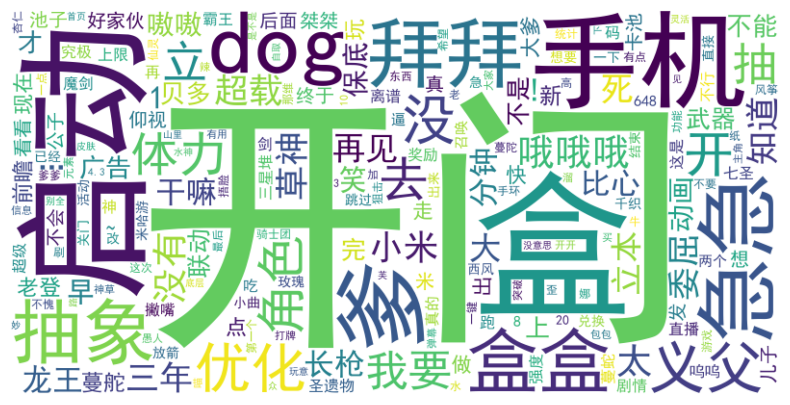

In [26]:
sentiment_df = df[df['sentiment'] == -1]
from wordcloud import WordCloud

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
sentiment_df = df[df['sentiment'] == -1]

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
top_15_mids = sentiment_df['mid'].value_counts().head(3544)

# Ê±áÊÄªÊâÄÊúâÈÄâÂÆömidÁöÑcontentÂÄº
all_content = []
for mid in top_15_mids.index:
    content_values = sentiment_df[sentiment_df['mid'] == mid]['content'].tolist()
    all_content.extend(content_values)

# Â∞ÜÊâÄÊúâcontentÂÄºËøûÊé•Êàê‰∏Ä‰∏™Â≠óÁ¨¶‰∏≤ÔºåÂêåÊó∂ÁßªÈô§Êç¢Ë°åÁ¨¶ÂíåÂ§ö‰ΩôÁ©∫Ê†º
text = ' '.join(all_content).replace('\n', ' ').replace('\r', ' ').strip()

# ‰ΩøÁî® jieba ÂàÜËØç
words = jieba.lcut(text)

# Âä†ËΩΩÂÅúÁî®ËØçË°®
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# ÂéªÈô§ÂÅúÁî®ËØç
words = [word for word in words if word not in stopwords and len(word.strip()) > 0]

# ‰ΩøÁî® pandas ËÆ°ÁÆóÊØè‰∏™ËØçÁöÑÈ¢ëÁéá
word_freq = pd.Series(words).value_counts()

# ÁîüÊàêËØç‰∫ë
wordcloud = WordCloud(width=800, height=400, font_path='simhei.ttf', background_color='white').generate_from_frequencies(word_freq)

# ÊòæÁ§∫ËØç‰∫ë
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # ÂÖ≥Èó≠ÂùêÊ†áËΩ¥
plt.show()

In [27]:
word_freq.head(10)

ÂºÄÈó®     2867
Áõí       432
ÂêØÂä®      318
ÊâãÊú∫      265
Áàπ       190
dog     180
ÊÄ•ÊÄ•      158
ÊãúÊãú      135
ÊäΩË±°      121
ÁõíÁõí      120
Name: count, dtype: int64

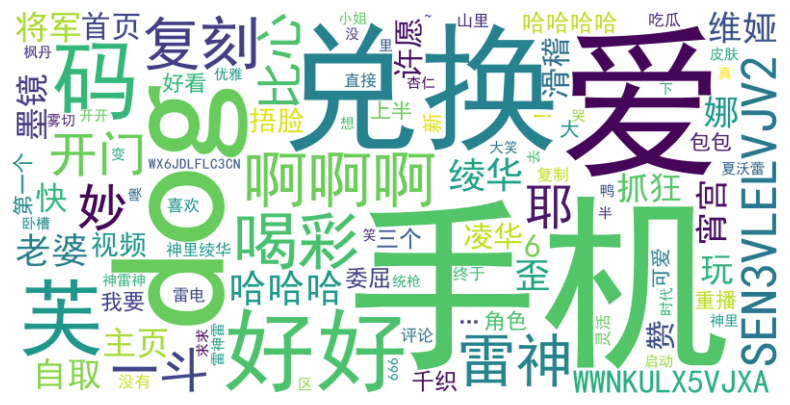

In [28]:
from wordcloud import WordCloud

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
sentiment_df = df[df['sentiment'] == 1]

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
top_15_mids = sentiment_df['mid'].value_counts().head(3544)

# Ê±áÊÄªÊâÄÊúâÈÄâÂÆömidÁöÑcontentÂÄº
all_content = []
for mid in top_15_mids.index:
    content_values = sentiment_df[sentiment_df['mid'] == mid]['content'].tolist()
    all_content.extend(content_values)

# Â∞ÜÊâÄÊúâcontentÂÄºËøûÊé•Êàê‰∏Ä‰∏™Â≠óÁ¨¶‰∏≤ÔºåÂêåÊó∂ÁßªÈô§Êç¢Ë°åÁ¨¶ÂíåÂ§ö‰ΩôÁ©∫Ê†º
text = ' '.join(all_content).replace('\n', ' ').replace('\r', ' ').strip()

# ‰ΩøÁî® jieba ÂàÜËØç
words = jieba.lcut(text)

# Âä†ËΩΩÂÅúÁî®ËØçË°®
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# ÂéªÈô§ÂÅúÁî®ËØç
words = [word for word in words if word not in stopwords and len(word.strip()) > 0 ]

# ‰ΩøÁî® pandas ËÆ°ÁÆóÊØè‰∏™ËØçÁöÑÈ¢ëÁéá
word_freq = pd.Series(words).value_counts()

# ÁîüÊàêËØç‰∫ë
wordcloud = WordCloud(width=800, height=400, font_path='simhei.ttf', background_color='white',max_words=100).generate_from_frequencies(word_freq)

# ÊòæÁ§∫ËØç‰∫ë
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # ÂÖ≥Èó≠ÂùêÊ†áËΩ¥
plt.show()

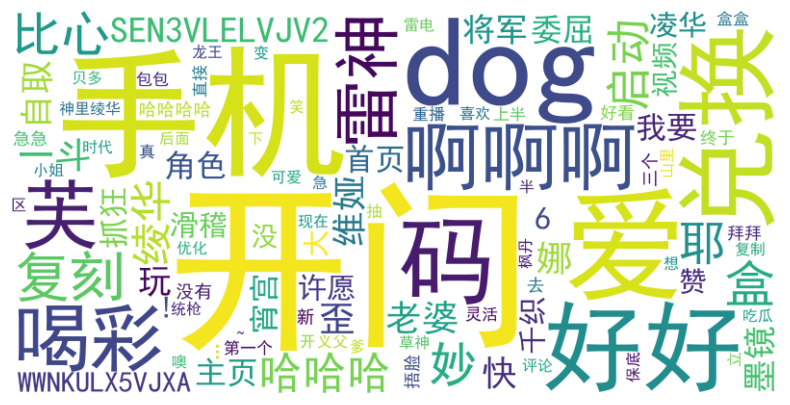

In [29]:
from wordcloud import WordCloud

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
sentiment_df = df

# ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞ÊúÄÂ§öÁöÑ15‰∏™mid
top_15_mids = sentiment_df['mid'].value_counts().head(4544)

# Ê±áÊÄªÊâÄÊúâÈÄâÂÆömidÁöÑcontentÂÄº
all_content = []
for mid in top_15_mids.index:
    content_values = sentiment_df[sentiment_df['mid'] == mid]['content'].tolist()
    all_content.extend(content_values)

# Â∞ÜÊâÄÊúâcontentÂÄºËøûÊé•Êàê‰∏Ä‰∏™Â≠óÁ¨¶‰∏≤ÔºåÂêåÊó∂ÁßªÈô§Êç¢Ë°åÁ¨¶ÂíåÂ§ö‰ΩôÁ©∫Ê†º
text = ' '.join(all_content).replace('\n', ' ').replace('\r', ' ').strip()

# ‰ΩøÁî® jieba ÂàÜËØç
words = jieba.lcut(text)

# Âä†ËΩΩÂÅúÁî®ËØçË°®
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# ÂéªÈô§ÂÅúÁî®ËØç
words = [word for word in words if word not in stopwords and len(word.strip()) > 0]

# ‰ΩøÁî® pandas ËÆ°ÁÆóÊØè‰∏™ËØçÁöÑÈ¢ëÁéá
word_freq = pd.Series(words).value_counts()

# ÁîüÊàêËØç‰∫ë
wordcloud = WordCloud(width=800, height=400, font_path='simhei.ttf', background_color='white',max_words=100).generate_from_frequencies(word_freq)

# ÊòæÁ§∫ËØç‰∫ë
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # ÂÖ≥Èó≠ÂùêÊ†áËΩ¥
plt.show()

In [30]:
word_freq[:30]

ÂºÄÈó®              2958
ÊâãÊú∫              1789
dog             1365
Áà±               1214
ÂÖëÊç¢               833
Â•ΩÂ•Ω               765
Á†Å                739
ÂïäÂïäÂïä              678
Ëäô                660
ÂñùÂΩ©               627
Èõ∑Á•û               503
Â§çÂàª               503
Áõí                433
ÊØîÂøÉ               399
Â¶ô                383
ËÄ∂                373
ÂêØÂä®               360
ÂìàÂìàÂìà              336
Áª´Âçé               328
SEN3VLELVJV2     316
‰∏ÄÊñó               316
Ê≠™                309
Â®ú                305
ËÄÅÂ©Ü               301
Áª¥Â®Ö               280
Âø´                279
Ëá™Âèñ               264
Â¢®Èïú               251
Áé©                250
Â∞ÜÂÜõ               238
Name: count, dtype: int64